# Deep learning basics from scratch for linear models - data management, optimizers & learning  rate schedulers

Things in this notebook:
- simple regression problem
- data management from scratch
- optimizers from scratch incl. monitoring & learning rate scheduling
- pretty visualizations

In this notebook I experiment with creating a custom dataset and transform as well as with creating some optimizers from scratch using pytorch. My personal highlight was to see that even a method like Covariance Matrix Adaption (an evolutionary strategy based algorithm) can be implemented using pytorch and actually performs reasonably well.

A bit surprising, and I suspect a bug is, is that the default SGD optimizer from pytorch performs quite poorly in comparison.


**TO DO: cyclical learning rates & LR range test: [Smith et al. 2017](https://arxiv.org/abs/1506.01186), [Smith and Topin 2018](https://arxiv.org/pdf/1708.07120.pdf), [medium blog](https://medium.com/dsnet/the-1-cycle-policy-an-experiment-that-vanished-the-struggle-in-training-neural-nets-184417de23b9) post by Shubhaajit Das, [Smith 2018](http://arxiv.org/abs/1803.09820)**

**TO DO: visualization of the loss surface in model weights space**

In [1]:
%matplotlib inline

In [2]:
from fastai.basics import torch

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Union
from functools import partial

import bokeh.io as bokeh_io
import bokeh.plotting as bokeh_plotting
import bokeh.models as bokeh_models
import bokeh.palettes as bokeh_palettes

from ipywidgets import interactive

In [3]:
bokeh_io.output_notebook()

Loading BokehJS ...

## Generating data

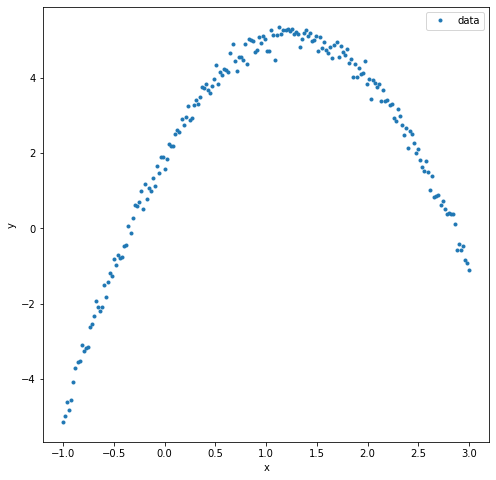

In [4]:
def polynomify(x: torch.Tensor, deg: int):
    X = torch.empty(len(x), deg)
    for i in range(deg):
        X[:,i] = x ** (deg-i-1)
    return X

n_obs = 200
x = torch.linspace(-1, 3, n_obs)
# w = torch.tensor([2., 1., 10.])
w = torch.tensor([-2., 5, 2.])
deg = len(w)
X = polynomify(x, deg)
y_err = stats.norm(loc=0, scale=.2).rvs(size=x.shape[0])
y_err = torch.from_numpy(y_err)
y_fun = lambda x: x@w + y_err

y = y_fun(X)
figsize = (8,8)
fig, ax = plt.subplots(figsize=figsize)
ax.plot(x, y, ".", label="data")
ax.set_xlabel("x")
ax.set_ylabel("y")
# ax.set_aspect("equal")
ax.legend()
plt.show()

In [5]:
x.size(), y.size(), X.size(), w.size()

(torch.Size([200]), torch.Size([200]), torch.Size([200, 3]), torch.Size([3]))

In [6]:
def MSELoss(pred, truth):
    Δ = pred - truth
    Δ2 = Δ * Δ
    return Δ2.mean()

def RMSELoss(pred, truth):
    Δ = pred - truth
    Δ2 = Δ * Δ
    return torch.sqrt(Δ2.mean())

In [7]:
MSELoss(X@w, y), RMSELoss(X@w, y)

(tensor(0.0363, dtype=torch.float64), tensor(0.1904, dtype=torch.float64))

In [8]:
def get_split_indices(n: int, val_pct: float = .2):
    val_pct = .2
    n_val = int(n*val_pct)
    ix = torch.randperm(n) 
    return ix[n_val:], ix[:n_val]

ix_train, ix_val = get_split_indices(n_obs, val_pct=.2)
print(ix_train.size(), ix_val.size())

torch.Size([160]) torch.Size([40])


## Custom data set and data loader

In [9]:
class XYDataset:
    "Basic data storage"
    def __init__(self, x: torch.tensor, y: torch.tensor):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    

def noisify(xy, device="cpu", std_x=.1, std_y=.1):
    x, y = xy
    if not torch.is_tensor(x):
        x = torch.from_numpy(x).clone().to(device)
    if not torch.is_tensor(y):
        y = torch.from_numpy(y).clone().to(device)
    
    
    dx = torch.normal(mean=0., std=std_x, size=x.size()).to(device)
    dy = torch.normal(mean=0., std=std_x, size=y.size()).to(device)
    return x + dx, y + dy


def random_order(end, bs):
    ix = torch.randperm(end)
    for i in range(0, end, bs):
        yield ix[i:i+bs]
        
def boring_order(end, bs):
    ix = torch.arange(end)
    for i in range(0, end, bs):
        yield ix[i:i+bs]
        
    
class XYDataLoader:
    "Provides an iterator (plus sampler) and transforms over stored data"
    def __init__(self, ds: XYDataset, bs: int = 1, sampler_callback: callable=None, trafos: List[callable]=None):
        self.ds = ds
        self.bs = bs
        self.sampler = sampler_callback if sampler_callback is not None else boring_order
        self.trafos = trafos
        
    def transform_batch(self, batch):
        if self.trafos is not None:
            for trafo in self.trafos:
                batch = trafo(batch)
        return batch
        
    def __iter__(self):
        for s in self.sampler(len(self.ds), self.bs):
            yield self.transform_batch(self.ds[s])


class XYDatabunch:
    "Bunches different data loaders"
    g: dict = {"train": None, "valid": None}
    
    def __init__(self, dl_train: XYDataLoader, dl_valid: XYDataLoader):
        self.dl_train = dl_train
        self.dl_valid = dl_valid
        
    def one_batch(self):
        return self.get_data(kind="train", reset_if_end=True)
    
    def reset_iterator(self, kind): self.g[kind] = iter(getattr(self, f"dl_{kind}"))
    
    def _get_data(self, kind: str = "train", reset: bool = True):
        if self.g[kind] is None or reset is True: 
            self.reset_iterator(kind)
        return next(self.g[kind], (None, None))
    
    def get_data(self, kind: str = "train", reset_if_end: bool = True):
        
        assert kind in self.g
        out = self._get_data(kind, reset_if_end)
        if out[0] is None and reset_if_end is True:
            return self._get_data(reset=True)
        if out[0] is None:
            raise StopIteration
        return out


In [10]:
bs_train, bs_valid = 40, 20
ds_train = XYDataset(X[ix_train], y[ix_train])
ds_valid = XYDataset(X[ix_val], y[ix_val])
dl_train = XYDataLoader(ds_train, bs=bs_train, sampler_callback=random_order, # random_order boring_order
                        trafos=None)  # [partial(noisify, std_x=.001)]
dl_valid = XYDataLoader(ds_valid, bs=bs_valid, sampler_callback=random_order, 
                        trafos=None)  # [partial(noisify, std_x=.001)]
db = XYDatabunch(dl_train, dl_valid)

In [11]:
print(db.get_data("train"))

(tensor([[ 5.7577e-01, -7.5879e-01,  1.0000e+00],
        [ 2.4749e-01, -4.9749e-01,  1.0000e+00],
        [ 4.2022e-01,  6.4824e-01,  1.0000e+00],
        [ 1.3358e-02, -1.1558e-01,  1.0000e+00],
        [ 4.0605e+00,  2.0151e+00,  1.0000e+00],
        [ 5.2738e+00,  2.2965e+00,  1.0000e+00],
        [ 1.6679e+00,  1.2915e+00,  1.0000e+00],
        [ 2.8002e+00,  1.6734e+00,  1.0000e+00],
        [ 6.9601e+00,  2.6382e+00,  1.0000e+00],
        [ 2.0511e+00,  1.4322e+00,  1.0000e+00],
        [ 1.8820e+00,  1.3719e+00,  1.0000e+00],
        [ 1.1136e-02,  1.0553e-01,  1.0000e+00],
        [ 2.1091e+00,  1.4523e+00,  1.0000e+00],
        [ 1.7396e-01, -4.1709e-01,  1.0000e+00],
        [ 7.2978e-03,  8.5427e-02,  1.0000e+00],
        [ 1.0612e+00,  1.0302e+00,  1.0000e+00],
        [ 2.0454e-03,  4.5226e-02,  1.0000e+00],
        [ 2.1840e-01,  4.6734e-01,  1.0000e+00],
        [ 8.1756e+00,  2.8593e+00,  1.0000e+00],
        [ 7.9473e+00,  2.8191e+00,  1.0000e+00],
        [ 3.2244e-0

In [12]:
_x, _y = db.get_data("train")
_x.size(), _y.size()

(torch.Size([40, 3]), torch.Size([40]))

In [13]:
db.one_batch()

(tensor([[ 5.2738e+00,  2.2965e+00,  1.0000e+00],
         [ 1.8273e+00,  1.3518e+00,  1.0000e+00],
         [ 8.2043e-02,  2.8643e-01,  1.0000e+00],
         [ 1.0669e-01,  3.2663e-01,  1.0000e+00],
         [ 4.6691e-02, -2.1608e-01,  1.0000e+00],
         [ 7.7223e+00,  2.7789e+00,  1.0000e+00],
         [ 2.5759e-01,  5.0754e-01,  1.0000e+00],
         [ 3.2183e+00,  1.7940e+00,  1.0000e+00],
         [ 1.6568e-01,  4.0704e-01,  1.0000e+00],
         [ 1.3709e+00,  1.1709e+00,  1.0000e+00],
         [ 3.0757e+00,  1.7538e+00,  1.0000e+00],
         [ 3.8204e-01, -6.1809e-01,  1.0000e+00],
         [ 6.5455e-01,  8.0905e-01,  1.0000e+00],
         [ 7.6109e+00,  2.7588e+00,  1.0000e+00],
         [ 2.0511e+00,  1.4322e+00,  1.0000e+00],
         [ 9.1159e-03, -9.5477e-02,  1.0000e+00],
         [ 5.4567e-01, -7.3869e-01,  1.0000e+00],
         [ 1.0000e+00, -1.0000e+00,  1.0000e+00],
         [ 2.0454e-03,  4.5226e-02,  1.0000e+00],
         [ 1.9939e+00,  1.4121e+00,  1.0000e+00],


In [14]:
print(db.get_data("valid"))

(tensor([[ 1.5157e+00,  1.2312e+00,  1.0000e+00],
        [ 3.5759e-01, -5.9799e-01,  1.0000e+00],
        [ 1.1336e-01, -3.3668e-01,  1.0000e+00],
        [ 3.9001e+00,  1.9749e+00,  1.0000e+00],
        [ 1.0022e-01, -3.1658e-01,  1.0000e+00],
        [ 5.3092e-01,  7.2864e-01,  1.0000e+00],
        [ 9.6020e-01, -9.7990e-01,  1.0000e+00],
        [ 2.4267e-02, -1.5578e-01,  1.0000e+00],
        [ 5.4601e+00,  2.3367e+00,  1.0000e+00],
        [ 1.2373e-03, -3.5176e-02,  1.0000e+00],
        [ 8.2728e-01,  9.0955e-01,  1.0000e+00],
        [ 7.0425e-01, -8.3920e-01,  1.0000e+00],
        [ 1.0202e+00,  1.0101e+00,  1.0000e+00],
        [ 6.6455e+00,  2.5779e+00,  1.0000e+00],
        [ 3.0934e-02, -1.7588e-01,  1.0000e+00],
        [ 2.6020e+00,  1.6131e+00,  1.0000e+00],
        [ 5.5544e+00,  2.3568e+00,  1.0000e+00],
        [ 5.6062e-01,  7.4874e-01,  1.0000e+00],
        [ 4.6474e+00,  2.1558e+00,  1.0000e+00],
        [ 1.2333e+00,  1.1106e+00,  1.0000e+00]]), tensor([ 5.2445, 

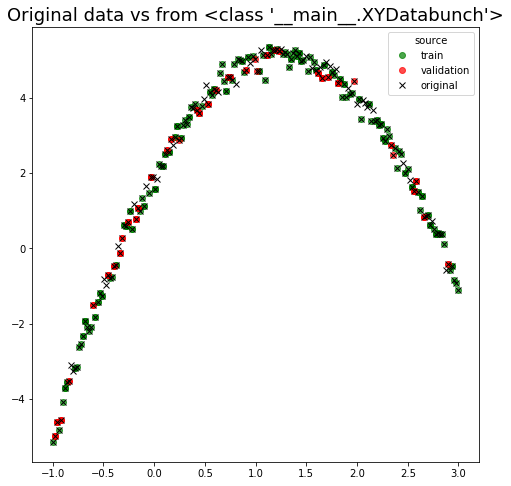

In [15]:
fig, ax = plt.subplots(figsize=figsize)
for _ in range(5):
    _x, _y = db.get_data("train")
    h_train, = ax.plot(_x[:, -2], _y, "go", label="train", alpha=.7)
for _ in range(5):
    _x, _y = db.get_data("valid")
    h_valid, = ax.plot(_x[:, -2], _y, "ro", label="validation", alpha=.7)
    
h_ori, = ax.plot(x, y, "kx", label="original")
ax.set_title(f"Original data vs from {db.__class__}", fontsize=18)
ax.legend(handles=[h_train, h_valid, h_ori], title="source")
plt.show()

In [16]:
class LinearModel:
    
    def __init__(self, w: torch.Tensor=None, deg: int = None):
        assert w is not None or deg is not None
        self.w = torch.nn.Parameter(torch.randn(deg)) if w is None else torch.nn.Parameter(w)
        self.lin = lambda X: X @ self.w
        
    def __call__(self, x):
        return self.forward(x)
            
    def forward(self, x):
        return self.lin(x)

In [17]:
lm_ori = LinearModel(w=w)
lm_ori(db.get_data("train")[0])

tensor([ 5.1043,  4.4483,  3.0181,  1.2709,  3.9620, -2.9455, -0.9824,  4.9165,
        -1.0000,  0.0739,  4.5386,  5.0283,  5.1117,  3.0998,  4.6174,  4.3947,
        -1.8545,  1.3817,  3.8999,  3.1799,  3.2681,  3.4198,  0.3262,  4.4425,
         0.3418, -0.1849,  2.8498, -3.9437,  3.4105, -3.7733, -0.1685,  5.1174,
         5.1250, -3.1078, -1.5574,  4.2484,  4.7317, -0.5852,  4.9652, -2.4682],
       grad_fn=<MvBackward>)

In [18]:
RMSELoss(lm_ori(X), y)

tensor(0.1904, dtype=torch.float64, grad_fn=<SqrtBackward>)

In [82]:
class Optimizer:
    
    name: str = None
    hyper_params: dict = None
    model_params = None
    
    def __init__(self, model_params, name="optimizer", **hyper_params):
        self.hyper_params = hyper_params
        self.name = name
        self.model_params = model_params
        
    def update(self):
        pass
    
    def zero_grad(self):
        self.model_params.grad.zero_()
    
    def __getattr__(self, k):
        return self.hyper_params[k]
    
    def __setattr__(self, key, val):
        
        if "hyper_params" in self.__dict__ and key in self.hyper_params:
            self.hyper_params[key] = val
        else:
            self.__dict__[key] = val


class Telemetry:
    loss: dict = None
    weights: list = None
    hyper_params: dict = None
    x: list = None
    y: list = None
    y_pred: list = None
    gradients: list = None
        
    def __repr__(self):
        return f"\nTelemetry\n{9*'='}\n"\
               f"loss: {self.loss}\n"\
               f"weights: {self.weights}\n"\
               f"hyper_params: {self.hyper_params}\n"\
               f"x: {self.x}\n"\
               f"y: {self.y}\n"\
               f"y_pred: {self.y_pred}\n"\
               f"gradients: {self.gradients}"
        
    
class Recorder:
    "Collects data while training"
    stats: Telemetry = None 
        
    def __init__(self, stats: Telemetry = None):
        if stats is None:
            stats = Telemetry()
        self.stats = stats
    
    def store_loss(self, kind, val):
        v = val.clone().detach().item() if isinstance(val, torch.Tensor) else val
        
        if self.stats.loss is None:
            self.stats.loss = {kind: [v]}
        elif kind not in self.stats.loss:
            self.stats.loss[kind] = [v]
        else:
            self.stats.loss[kind].append(v)
    
    def store_hyper_params(self, opt: Optimizer):
        
        convert = lambda x: x.item() if isinstance(x, torch.Tensor) else x
        if self.stats.hyper_params is None:
            self.stats.hyper_params = {}
            for key, val in opt.hyper_params.items():
                self.stats.hyper_params[key] = [convert(val)]
        else:
            for key, val in opt.hyper_params.items():
                self.stats.hyper_params[key].append(convert(val))
                
    def store_weights(self, model_params):
        if self.stats.weights is None:
            self.stats.weights = []
        self.stats.weights.append(model_params.clone().detach())
        
    def store_batch(self, _x: torch.Tensor, _y: torch.Tensor, y_pred: torch.Tensor):
        if self.stats.x is None:
            self.stats.x = []
        if self.stats.y is None:
            self.stats.y = []
        if self.stats.y_pred is None:
            self.stats.y_pred = []
        
        self.stats.x.append(_x.clone().detach())
        self.stats.y.append(_y.clone().detach())
        self.stats.y_pred.append(y_pred.clone().detach())
        
    def store_gradients(self, g):
        if self.stats.gradients is None:
            self.stats.gradients = []
        self.stats.gradients.append(g.clone().detach())
        
        
class Plotter:
    
    stats : Telemetry = None
        
    def __init__(self, rec: Recorder = None, stats: Telemetry = None):
        assert (rec is not None) != (stats is not None)
        self.stats = rec.stats if rec is not None else stats
    
    def plot_loss(self):
        
        iters = np.arange(len(self.stats.loss["train"]))
        
        colors = bokeh_palettes.Inferno3
        
        fig = bokeh_plotting.figure(plot_width=700, plot_height=400, title="Losses vs iteration")
        
        s = bokeh_plotting.ColumnDataSource({"Iteration": iters, 
                                             "Loss": self.stats.loss["train"],
                                             "Group": ["Train"]*len(iters)})
        fig.line(x="Iteration", y="Loss", source=s, color=colors[0],
                 line_width=2)
        
        
        s = bokeh_plotting.ColumnDataSource({"Iteration": iters, 
                                             "Loss": self.stats.loss["valid"],
                                             "Group": ["Validation"]*len(iters)})
        fig.line(x="Iteration", y="Loss", source=s, color=colors[1],
                 line_width=2)
        
        hover = bokeh_models.HoverTool(
            tooltips = [
                ("Iteration", "@Iteration"),
                ("Loss", "@Loss"),
                ("Set", "@Group"),
            ],
            formatters = {"Iteration": "numeral", "Loss": "numeral", "Set": "printf"},
            mode="vline"
        )
        fig.xaxis.axis_label = "Iteration"
        fig.yaxis.axis_label = "Loss"
        fig.tools.append(hover)
        bokeh_plotting.show(fig)
        
    def plot_weights(self, colors: list=None):
        
        iters = np.arange(len(self.stats.loss["train"]))
        w = np.array([_w.clone().detach().numpy() for _w in self.stats.weights])
        colors = bokeh_palettes.Inferno3 if colors is None else colors
        
        fig = bokeh_plotting.figure(plot_width=700, plot_height=400, title="Model weights vs iteration")       
        
        for i, _w in enumerate(w.T):
            
            s = bokeh_plotting.ColumnDataSource({"Iteration": iters, "w": _w, "param": [f"w_{i}"]*len(iters)})       
            fig.line(x="Iteration", y="w", source=s, color=colors[i], line_width=2)
            
        tooltips = [
                ("Iteration", "@Iteration"), ("Value", "@w"), ("Name", "@param")
            ]
        hover = bokeh_models.HoverTool(
            tooltips = tooltips,
            formatters = {"Iteration": "numeral", "Value": "numeral", "Name": "printf"},
            mode="vline"
        )
        fig.tools.append(hover)
        bokeh_plotting.show(fig)
        
        
    def plot_gradients(self, colors: list=None):
        
        iters = np.arange(len(self.stats.loss["train"]))
        g = np.array([_g.clone().detach().numpy() for _g in self.stats.gradients])
        colors = bokeh_palettes.Inferno3 if colors is None else colors
        
        fig = bokeh_plotting.figure(plot_width=700, plot_height=400, title="Model weight gradients vs iteration")       
        
        for i, _g in enumerate(g.T):
            
            s = bokeh_plotting.ColumnDataSource({"Iteration": iters, "∇w": _g, "param": [f"∇w_{i}"]*len(iters)})       
            fig.line(x="Iteration", y="∇w", source=s, color=colors[i], line_width=2)
            
        tooltips = [
                ("Iteration", "@Iteration"), ("Value", "@{∇w}"), ("Name", "@param")
            ]
        hover = bokeh_models.HoverTool(
            tooltips = tooltips,
            formatters = {"Iteration": "numeral", "Value": "numeral", "Name": "printf"},
            mode="vline"
        )
        fig.tools.append(hover)
        bokeh_plotting.show(fig)
        
                
    def plot_hyper_params(self):
        
        iters = np.arange(len(self.stats.loss["train"]))
        colors = bokeh_palettes.Inferno256
        
        for hyper in sorted(self.stats.hyper_params):
            s = bokeh_plotting.ColumnDataSource({"Iteration": iters, hyper: self.stats.hyper_params[hyper]})
        
            fig = bokeh_plotting.figure(plot_width=700, plot_height=400, 
                                        title=f"Hyper parameters ('{hyper}') vs iteration")
            
            fig.line(x="Iteration", y=hyper, source=s, legend_label=hyper, line_width=2)
            

            tooltips = [
                ("Iteration", "@Iteration"),                    
                (hyper, f"@{hyper}")
            ]
            
            hover = bokeh_models.HoverTool(
                tooltips = tooltips,
                formatters = {k[0]: "numeral" for k in tooltips},
                mode="mouse"
            )
            fig.tools.append(hover)
            bokeh_plotting.show(fig)
            
    def plot_iteration(self, i: int):
        
        x = self.stats.x[i][:, -2].clone().numpy() # -2 because second to last column contains x**1 feature
        
        _x = np.hstack([_x[:, -2].clone().numpy().ravel() for _x in self.stats.x])
        xlim = (_x.min()-.1, _x.max()+.1)

        _y = np.array([_y.clone().numpy() for _y in self.stats.y])
        ylim = (_y.min()-.1, _y.max()+.1)

        
        fig = bokeh_plotting.figure(plot_width=600, plot_height=600, 
                                    title=f"Batch and predictions for iteration {i}")
        
        fig.cross(x, self.stats.y[i].clone().numpy(), legend_label="training data", color="black",
                  size=10) 
        fig.diamond(x, self.stats.y_pred[i].clone().numpy(), legend_label="model estimates", 
                    color="green", size=10)
        fig.xaxis.axis_label = "x"
        fig.yaxis.axis_label = "y"
        fig.x_range = bokeh_models.Range1d(xlim[0], xlim[1])
        fig.y_range = bokeh_models.Range1d(ylim[0], ylim[1])
        bokeh_plotting.show(fig)
        
    def plot_lr_range_test(self):
        fig = bokeh_plotting.figure(title="LR range test", x_axis_type="log")
        s = bokeh_models.ColumnDataSource({"lr": self.stats.hyper_params["lr"], 
                                           "loss": self.stats.loss["valid"]})
        fig.line(x="lr", y="loss", source=s)
        fig.xaxis.axis_label = "Learning rate"
        fig.yaxis.axis_label = "Validation loss"

        hover = bokeh_models.HoverTool(
            tooltips=[("Learning rate", "@lr"), ("Validation loss", "@loss")],
            formatters={"Learning rate": "numeral", "Validation loss": "numeral"}
        )
        fig.tools.append(hover)

        bokeh_plotting.show(fig)

Sanity checking the recorder

In [83]:
rec = Recorder()
loss_fun = MSELoss

n_epochs = 5
opt = Optimizer(None, lr=.1)
print("total epochs", n_epochs)
for epoch in range(n_epochs):
    print(f"\nepoch {epoch}")
    rec.store_loss("train", 42)
    rec.store_loss("valid", 82.)
    
    print("\tlr", opt.lr * .9)
    opt.lr *= .9
    rec.store_hyper_params(opt)
    rec.store_weights(torch.Tensor([1., 2., 3.]))
    _x, _y = db.get_data("train")
    
    rec.store_gradients(torch.tensor([.1, .2, .3]))
    with torch.no_grad():
        y_pred = _y + .1
    rec.store_batch(_x, _y, y_pred)

total epochs 5

epoch 0
	lr 0.09000000000000001

epoch 1
	lr 0.08100000000000002

epoch 2
	lr 0.07290000000000002

epoch 3
	lr 0.06561000000000002

epoch 4
	lr 0.05904900000000002


In [84]:
rec.stats


Telemetry
loss: {'train': [42, 42, 42, 42, 42], 'valid': [82.0, 82.0, 82.0, 82.0, 82.0]}
weights: [tensor([1., 2., 3.]), tensor([1., 2., 3.]), tensor([1., 2., 3.]), tensor([1., 2., 3.]), tensor([1., 2., 3.])]
hyper_params: {'lr': [0.09000000000000001, 0.08100000000000002, 0.07290000000000002, 0.06561000000000002, 0.05904900000000002]}
x: [tensor([[ 1.8820e+00,  1.3719e+00,  1.0000e+00],
        [ 5.9399e+00,  2.4372e+00,  1.0000e+00],
        [ 4.4668e-01,  6.6834e-01,  1.0000e+00],
        [ 6.3130e-04,  2.5126e-02,  1.0000e+00],
        [ 4.7345e+00,  2.1759e+00,  1.0000e+00],
        [ 6.5455e-01,  8.0905e-01,  1.0000e+00],
        [ 9.4061e-01,  9.6985e-01,  1.0000e+00],
        [ 1.2784e+00,  1.1307e+00,  1.0000e+00],
        [ 5.8423e+00,  2.4171e+00,  1.0000e+00],
        [ 3.8408e-02, -1.9598e-01,  1.0000e+00],
        [ 2.8911e-01, -5.3769e-01,  1.0000e+00],
        [ 1.3709e+00,  1.1709e+00,  1.0000e+00],
        [ 4.8223e+00,  2.1960e+00,  1.0000e+00],
        [ 9.0202e-01,

In [85]:
len(rec.stats.hyper_params["lr"]), len(rec.stats.loss["train"])

(5, 5)

In [86]:
pl = Plotter(rec=rec)
pl.plot_loss()
pl.plot_hyper_params()
pl.plot_weights()
pl.plot_gradients()
pl.plot_lr_range_test()

In [25]:
interactive_plot = interactive(pl.plot_iteration, i=(0, len(pl.stats.x)-1))
interactive_plot

interactive(children=(IntSlider(value=2, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

In [87]:
class SGD(Optimizer):
    
    velocity = None
    
    def __init__(self, model_params, lr: float = .01, momentum=0., wd=0.):
        super().__init__(model_params, name="SGD", lr=lr, momentum=momentum, wd=wd)
        if momentum > 0:
            self.velocity = torch.zeros_like(model_params)
        
    def update(self, **kwargs):
        
        with torch.no_grad():
            # some pretty naming
            w = self.model_params
            dw = self.model_params.grad
            
            lr = self.lr
            mom = self.momentum
            wd = self.wd
            
            v = self.velocity
            
            # doing the calculation
            if mom > 0 and np.isclose(wd, 0):
                v.mul_(mom)
                v.add_(dw * lr)
                w.sub_(v)
            elif mom > 0 and wd > 0:
                v.mul_(mom)
                v.add_(dw * lr)
                w.sub_(v + wd*w)
            else:
                w.sub_(dw * lr)
                    
            self.zero_grad()


class Adam(Optimizer):
    """
    paper: https://arxiv.org/abs/1412.6980
    """
    mom1 = None
    mom2 = None
    
    def __init__(self, model_params, lr=.01, betas=None, eps=1e-8):
        if betas is None:
            betas = [.9, .999]
        super().__init__(model_params, name="Adam", lr=lr, ε=eps, β1=betas[0], β2=betas[1])
        
        self.mom1 = torch.zeros_like(model_params)
        self.mom2 = torch.zeros_like(model_params)
        
    def update(self, t, **kwargs):
        
        with torch.no_grad():
            # pretty naming
            w = self.model_params
            dw = self.model_params.grad
            
            lr = self.lr
            β1 = self.β1
            β2 = self.β2
            ε = self.ε
            
            mom1 = self.mom1
            mom2 = self.mom2
            
            # doing the calculation
            mom1.mul_(β1)
            mom1.add_((1.-β1) * dw)
            mom1_hat = mom1.div(1. - β1**(t+1))
            
            mom2.mul_(β2)
            mom2.add_((1.-β2)*(dw*dw))
            mom2_hat = mom2.div(1.-β2**(t+1))
            
            w.sub_(lr * mom1_hat / (torch.sqrt(mom2_hat) + ε))
            
            
class CMA_ES(Optimizer):
    """    
    See p29 of: N. Hansen, The CMA Evolution Strategy: A Tutorial, 2016 or https://en.wikipedia.org/wiki/CMA-ES 
    for a more implementable version.
    
    Optimizer's hyper parameters
    ----------------------------
    λ: number of agents
    μ: number of children which survive the culling
    σ: step width
    """   
    # parameters 
    agent_weights = None  # how much each of the selected descendants will weigh in (first has best fitness)
    N = None  # problem dimension
    
    # Strategy parameter setting: Adaptation
    cc = None  # time constant for cumulation for C
    cs = None  # t-const for cumulation for sigma control
    c1 = None  # learning rate for rank-one update of C
    cmu = None
    damps = None  # damping for sigma, usually close to 1
        
    eigeneval = None  # track update of B and D
        
    def __init__(self, model_params, _lambda: int = None, mu: int = None, sigma: float = .3):
        
        self.N = len(model_params)
        
        if _lambda is None:
            _lambda = int(4. * np.floor(3*np.log(self.N)))
        if mu is None:
            mu = int(_lambda * .5)
        
        super().__init__(model_params, name="CMA-ES", _lambda=_lambda, mu=mu, sigma=sigma)
        
        with torch.no_grad():
            
            self.agent_weights = np.log(mu+.5) - torch.log(torch.arange(1,mu+1, dtype=torch.float32))
            self.agent_weights.div_(self.agent_weights.sum())
            
            self.mueff = self.agent_weights.sum().pow(2) / (self.agent_weights @ self.agent_weights).sum()
            
            self.cc = (4. + self.mueff / self.N) / (self.N + 4 + 2 * self.mueff / self.N) # time constant for cumulation for C
            self.cs = (self.mueff + 2) / (self.N + self.mueff + 5) # t-const for cumulation for sigma control
            self.c1 = 2 / ((self.N+1.3)**2 + self.mueff) # learning rate for rank-one update of C
            self.cmu = min([1 - self.c1, 2 * (self.mueff - 2 + 1 / self.mueff) / ((self.N + 2)**2 + self.mueff)])
            self.damps = 1 + 2 * max(0, torch.sqrt((self.mueff - 1)/(self.N + 1)) - 1) + self.cs # damping for sigma, usually close to 1
            
            self.pc = torch.zeros(1, self.N) # evolution paths for C and sigma
            self.ps = torch.zeros(1, self.N).detach() # evolution paths for C and sigma
            
            self.B = torch.eye(self.N, self.N).detach() # B defines the coordinate system
            self.D = torch.ones(self.N).detach() # diagonal D defines the scaling
            self.C = torch.eye(n=self.N, dtype=torch.float).detach()
            
            self.invsqrtC = self.B @ torch.diag(1 / self.D) @ self.B.transpose(0, 1)
            
            self.eigeneval = 0
            self.chiN = self.N**.5 * (1. - 1./(4.*self.N) + 1./(21.*self.N**2))
                           
    def update(self, t, _x, _y, model, loss_fun, **kwargs):

        with torch.no_grad():
                        
            λ = self._lambda
            μ = self.mu
            σ = self.sigma
            
            m = model.w
            
            C = self.C
            
            ps = self.ps
            cs = self.cs
            mueff = self.mueff
            invsqrtC = self.invsqrtC
            cc = self.cc
            pc = self.pc
            N = self.N
            chiN = self.chiN
            c1 = self.c1
            cmu = self.cmu
            agent_weights = self.agent_weights
            damps = self.damps
            eigeneval = self.eigeneval
            
            agents = (torch.distributions.multivariate_normal.MultivariateNormal(m, covariance_matrix = C)
                      .sample(sample_shape=torch.Size([λ])))
            
            fitnesses = torch.zeros(λ)
            for _i in range(λ):
                _w = torch.nn.Parameter(agents[_i])
                model.w = _w
                _y_pred = model(_x)
                fitnesses[_i] = loss_fun(_y_pred, _y)

            idx = torch.argsort(fitnesses)[:μ] # assumes that the best individuals are those with the lowest fitness values

            m_new = agents[idx].mean(dim=0)

            # Update evolution paths     
            ps = (1.-cs) * ps + torch.sqrt(cs * (2. - cs) * mueff) * invsqrtC @ (m_new - m)/σ

            hsig = torch.tensor(2./(N+1.))
            if not (torch.norm(ps) / torch.sqrt(1.-(1.-cs)**(2.*(t+1)/λ))/chiN < 1.4):
                hsig += 1.

            pc = (1.-cc) * pc + hsig * torch.sqrt(cc * (2.-cc)*mueff) * (m_new - m)/σ

            # Adapt covariance matrix C
            artmp = 1/σ * (agents[idx] - m)
            
            C = (1. - c1 - cmu) * C \
                      + c1 * ( \
                              torch.einsum("i,j->ij", pc[0], pc[0]) \
                              + (1-hsig) * cc*(2-cc) * C
                             ) \
                      + cmu * artmp.transpose(0, 1) @ torch.diag(agent_weights) @ artmp

            σ = σ * torch.exp((cs/damps)*(torch.norm(ps)/chiN - 1.))

            if t - eigeneval > λ/(c1+cmu)/N/10.:

                eigeneval = t
                C = C.triu() + C.triu(1).transpose(0, 1)
                (D, B) = C.eig(eigenvectors=True)
                invsqrtC = B @ torch.diag(1./D[:,0]) @ B.transpose(0, 1)

            self.model_params = torch.nn.Parameter(m_new)
            model.w = torch.nn.Parameter(m_new)
            
            self.sigma = σ  
            self.C = C
            self.ps = ps
            self.pc = pc
            self.invsqrtC = invsqrtC
            self.eigeneval = eigeneval
            
        
class PyTorchOpt(Optimizer):
        
    def __init__(self, model_params, opt: torch.optim.Optimizer, **hyper_params):
        super().__init__(model_params, name="pytorch optimizer", **hyper_params)
        self.opt = opt([model_params], **hyper_params)
        
    def update(self, **kwargs):
        self.opt.step()
        self.opt.zero_grad()


class RMSProp(Optimizer):
    """
    coursera course: https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf, 
    paper: http://arxiv.org/abs/1308.0850
    blog post: https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a
    """
    
    velocity = None
    magnitude = None
    
    def __init__(self, model_params, momentum=0., lr=.1, wd=0., beta=.99):
        super().__init__(model_params, name="RMSProp", lr=lr, momentum=momentum, wd=wd, beta=beta)
        self.velocity = torch.zeros_like(model_params)
        self.magnitude = torch.tensor(1.)
    
    def update(self, **kwargs):
        
        with torch.no_grad():
            # some pretty naming
            w = self.model_params
            dw = self.model_params.grad
            
            lr = self.lr
            mom = self.momentum
            wd = self.wd
            β = self.beta
            
            v = self.velocity
            mag = self.magnitude
            
            # doing the calculation
            mag.mul_(β)
            mag.add_((1.-β)*(w@w))
            
            v.mul_(mom)
            v.add_(lr/torch.sqrt(mag)*dw)
            
            w.sub_(v + wd*w)

In [196]:
class HyperParamsScheduler:
    
    hyper_params: dict = None
    schedule_params: dict = None
        
    def __init__(self, opt: Optimizer, **schedule_params):
        self.hyper_params = opt.hyper_params
        self.schedule_params = schedule_params
        
    def __getattr__(self, k):
        return self.schedule_params[k]
    
    def update(self, **kwargs):
        pass

            
class LRDecayScheduler(HyperParamsScheduler):
        
    def __init__(self, opt: Optimizer, _lambda: float = .9):
        super().__init__(opt, _lambda=_lambda)
        
    def update(self, epoch, **kwargs):
        self.hyper_params["lr"] = self.hyper_params["lr"] * self._lambda
        
class LRRangeEndException(Exception):
    """Exception raised when the end of the learning rate range test is reached
    """
    def __init__(self, message):
        super().__init__(message)
        
class LRRangeScheduler(HyperParamsScheduler):
        
    def __init__(self, opt: Optimizer, low: float = 1e-6, high: float = 1e1, steps: int = 10):
        lrs = np.logspace(np.log10(low), np.log10(high), steps)
        super().__init__(opt, lrs=lrs)
        
    def update(self, iteration, **kwargs):
        if iteration < len(self.schedule_params["lrs"]):
            self.hyper_params["lr"] = self.schedule_params["lrs"][iteration]
        else:
            raise LRRangeEndException("Reached the end of the iterations for the learning rate range test.")
        

class CyclicalLRScheduler(HyperParamsScheduler):
    """
    
    References:
    Smith et al. 2017, https://ieeexplore.ieee.org/abstract/document/7926641/
    Smith et al. 2018, http://arxiv.org/abs/1803.09820
    post on medium by Shubhaajit Das, https://medium.com/dsnet/the-1-cycle-policy-an-experiment-that-vanished-the-struggle-in-training-neural-nets-184417de23b9)
    """
    def __init__(self, opt: Optimizer, bs: int, num_samples: int, 
                 base_lr: float = 1e-3, max_lr: float = .5):
        
        super().__init__(opt, bs=bs, num_samples=num_samples, max_lr=max_lr, base_lr=base_lr)
        
    def update(self, iteration: int, start_epoch: int, end_epoch: int, 
               start_iteration: int, **kwargs):
        
        curr_step = iteration - start_iteration
        step_size = int( (end_epoch - start_epoch) * np.ceil(self.num_samples / self.bs) )
        Δlr = (self.max_lr - self.base_lr) / step_size
        sign = 1 if curr_step < .5 * step_size else -1
        self.hyper_params["lr"] += sign * Δlr
                
        
class Learner:
    "Manages the training"
    
    model = None  # model
    db = None  # data bunch
    opt = None  # optimizer
    rec = None  # recorder
    loss_fun = None
    hs = None  # hyper parameter scheduler
    epoch = 0
    iteration = 0
    curr_start_epoch = None
    curr_final_epoch = None
    
    def __init__(self, model, db: XYDatabunch, opt: Optimizer, loss_fun: MSELoss, rec: Recorder = None,
                 hyper_scheduler: HyperParamsScheduler=None):
        self.model = model
        self.db = db
        self.opt = opt
        self.loss_fun = loss_fun
        self.rec = rec if rec is not None else Recorder()
        self.hs = hyper_scheduler if hyper_scheduler is not None else HyperParamsScheduler(opt)
                        
    def do_epoch(self):
                
        # train
        self.db.reset_iterator("train")
        while True:
            
            try: # in case the hyper parameter scheduler is doing a lr range test
                self.hs.update(epoch=self.epoch, iteration=self.iteration, start_epoch = self.curr_start_epoch,
                               end_epoch = self.curr_end_epoch, start_iteration = self.curr_start_iteration)
            except LRRangeEndException:
                break
            
            try:
                (_x, _y) = self.db.get_data("train", reset_if_end=False)
            except StopIteration:
                break            
            
            _y_pred = self.model(_x)
            loss = self.loss_fun(_y_pred, _y)
            self.rec.store_loss("train", loss)
            if not self.opt.name == "CMA-ES":
                loss.backward()
            
            if not self.opt.name == "CMA-ES":
                self.rec.store_gradients(self.opt.model_params.grad)
            self.opt.update(t=self.epoch, _x=_x, _y=_y, model=self.model, loss_fun=self.loss_fun)
            self.rec.store_weights(self.opt.model_params)
            self.rec.store_batch(_x, _y, _y_pred)

            # validate
            with torch.no_grad():
                _x, _y = self.db.get_data("valid")
                _y_pred = self.model(_x)
                loss = self.loss_fun(_y_pred, _y)
                self.rec.store_loss("valid", loss)

            self.rec.store_hyper_params(self.opt)
            
            self.iteration += 1
    
        self.epoch += 1
        
    def fit(self, epochs: int=1):
        
        # iterations per epoch np.ceil(len(learn.db.dl_train.ds) / learn.db.dl_train.bs)
        # iters_per_epoch = 
        self.curr_start_epoch = self.epoch
        self.curr_end_epoch = self.epoch + epochs
        self.curr_start_iteration = self.iteration
        
        for epoch in range(epochs):
            self.do_epoch()
            
    def lr_range_test(self, low: float = 1e-6, high: float = 1e1, steps: int = 10):
        self.hs = LRRangeScheduler(self.opt, low=low, high=high, steps=steps)
        iter_per_epoch = int(np.ceil(len(self.db.dl_train.ds) / self.db.dl_train.bs))
        epochs = int(np.ceil(steps / iter_per_epoch))
        self.fit(epochs=epochs)

In [203]:
lm = LinearModel(deg=len(w))
opt = SGD(lm.w, lr=.1, momentum=0., wd=0.)
# opt = PyTorchOpt(lm.w, opt=torch.optim.SGD, lr=.1, momentum=.9, weight_decay=.1)
# opt = PyTorchOpt(lm.w, opt=torch.optim.Adam, lr=.1)
# opt = RMSProp(lm.w, lr=.1, momentum=0, wd=0, beta=.99)
# opt = Adam(lm.w, lr=.01, betas=[.9, .999], eps=1e-8)
# opt = CMA_ES(lm.w, sigma=.3)

lrs = None
# lrs = LRDecayScheduler(opt, _lambda=.98) 
# lrs = CyclicalLRScheduler(opt, bs=bs_train, num_samples=len(ds_train), base_lr=1e-3, max_lr=.5)

loss_fun = RMSELoss

learn = Learner(lm, db, opt, loss_fun, hyper_scheduler=lrs)

**Learning rate range test (optional)**

In [172]:
learn.lr_range_test(low=1e-6, high=1e0, steps=100, max_epochs=1000)

In [170]:
pl = Plotter(rec=learn.rec)
pl.plot_lr_range_test()

**Actual training**

In [204]:
opt.model_params, learn.epoch

(Parameter containing:
 tensor([ 0.1397,  1.1849, -0.3370], requires_grad=True), 0)

In [205]:
loss_fun(y, lm(X))

tensor(2.8652, dtype=torch.float64, grad_fn=<SqrtBackward>)

In [206]:
learn.fit(epochs=10)

In [207]:
lm.w, learn.epoch, opt.model_params

(Parameter containing:
 tensor([-0.8557,  2.5816,  1.2484], requires_grad=True),
 10,
 Parameter containing:
 tensor([-0.8557,  2.5816,  1.2484], requires_grad=True))

In [208]:
learn.rec.stats


Telemetry
loss: {'train': [2.6928342187091054, 2.6067294657987046, 3.1452077248283516, 2.8307314934900614, 2.5507302107633234, 2.7102831250762525, 2.8176720126492727, 2.5294444484471237, 2.486711957270775, 2.594518258977574, 2.424201407762693, 2.5118518975181026, 2.49672664365249, 2.2548124567227914, 2.426885341880698, 2.307498125589593, 1.8598472781801452, 2.2851997079267514, 2.332091632799124, 2.3279280089729077, 2.1181338721442935, 1.939942541354078, 2.1079742447703658, 2.198627152373356, 1.8864502709884643, 2.057404839521235, 2.0013428368225505, 1.9115280892094937, 1.8933309934678466, 1.6469490945467204, 1.867854005096164, 1.8068163632498182, 1.8822960393922226, 1.5799130770377776, 1.5913816814269572, 1.6833522663059441, 1.5587129523807992, 1.6300405906182205, 1.4539521398779391, 1.6334447359473006], 'valid': [2.8805072726499, 2.975416995864573, 2.492288997505582, 2.738740527927472, 2.5441909351595737, 3.0162037027358175, 2.5246838829436533, 2.6207816819034484, 2.312927819913425, 

In [209]:
loss_fun(y, lm_ori(X))

tensor(0.1904, dtype=torch.float64, grad_fn=<SqrtBackward>)

In [210]:
loss_fun(y, lm(X))

tensor(1.4771, dtype=torch.float64, grad_fn=<SqrtBackward>)

In [211]:
pl = Plotter(rec=learn.rec)
pl.plot_loss()

In [212]:
pl.plot_weights(colors=bokeh_palettes.Inferno10)

In [213]:
pl.plot_gradients(colors=bokeh_palettes.Inferno10)

In [214]:
pl.plot_hyper_params()

In [303]:
interactive_plot = interactive(pl.plot_iteration, i=(0, len(pl.stats.x)-1))
interactive_plot

interactive(children=(IntSlider(value=19, description='i', max=39), Output()), _dom_classes=('widget-interact'…

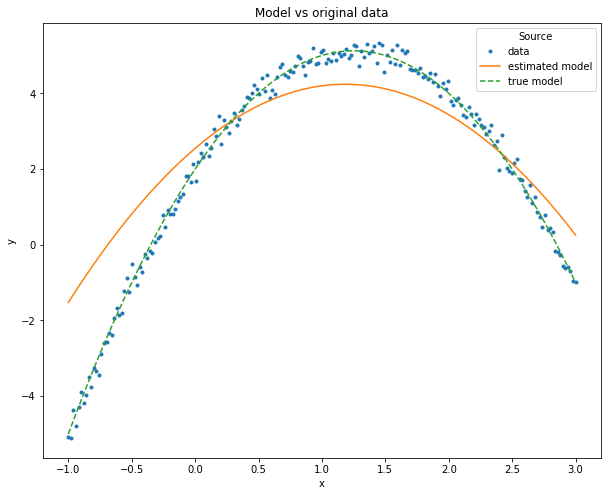

In [365]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, y, ".", label="data")

with torch.no_grad():
    _x = torch.linspace(x.min(), x.max(), 1000)
    ax.plot(_x, lm(polynomify(_x, deg)), "-", label="estimated model")
    ax.plot(_x, lm_ori(polynomify(_x, deg)), "--", label="true model")
ax.legend(title="Source")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Model vs original data")
plt.show()

## Comparing the optimizers

Setting the optimizer parameters

In [197]:
lm = LinearModel(deg=len(w))
setups = {
    "SGD": {
        "opt": {
            "params": dict(lr=.1, momentum=0, wd=0),
            "class": SGD
        }
    },
    "SGD-1cycle": {
        "opt": {
            "params": dict(lr=.1, momentum=0, wd=0),
            "class": SGD
        },
        "lrs": {
            "class": CyclicalLRScheduler,
            "params": dict(bs=bs_train, num_samples=len(ds_train), base_lr=1e-3, max_lr=.5)
        }
    },
    
#     "pytorch-SGD": {
#         "params": dict(opt=torch.optim.SGD, lr=.1, momentum=.9, weight_decay=.1),
#         "class": PyTorchOpt
#     },
#     "pytorch-Adam": {
#         "params": dict(opt=torch.optim.Adam, lr=.1),
#         "class": PyTorchOpt
#     },
#     "CMA-ES": {
#         "params": dict(sigma=.3),
#         "class": CMA_ES
#     },
#     "Adam": {
#         "params": dict(lr=.01, betas=[.9, .999], eps=1e-8),
#         "class": Adam
#     },
#     "RMSProp": {
#         "params": dict(lr=.1, momentum=0, wd=0, beta=.99),
#         "class": RMSProp
#     },
}

lrs = None  # LRDecayScheduler(opt, _lambda=.98) 
loss_fun = RMSELoss

n_trials = 20
n_epochs = 10
recs = {sname: [] for sname in setups}

Running the optimizers repeatedly

In [215]:
for i in range(n_trials):
    lm = LinearModel(deg=len(w))
    w_copy = lm.w.clone().detach()
    
    for sname in sorted(setups):
        print(f"{sname} {i+1}/{n_trials}")
        opt = setups[sname]["opt"]["class"](lm.w, **setups[sname]["opt"]["params"])
        lrs = None if "lrs" not in setups[sname] else setups[sname]["lrs"]["class"](opt, **setups[sname]["lrs"]["params"])
        learn = Learner(lm, db, opt, loss_fun, hyper_scheduler=lrs)
        learn.fit(epochs=n_epochs)
        recs[sname].append(learn.rec.stats)
        lm.w = torch.nn.Parameter(w_copy)

SGD 1/20
SGD-1cycle 1/20
SGD 2/20
SGD-1cycle 2/20
SGD 3/20
SGD-1cycle 3/20
SGD 4/20
SGD-1cycle 4/20
SGD 5/20
SGD-1cycle 5/20
SGD 6/20
SGD-1cycle 6/20
SGD 7/20
SGD-1cycle 7/20
SGD 8/20
SGD-1cycle 8/20
SGD 9/20
SGD-1cycle 9/20
SGD 10/20
SGD-1cycle 10/20
SGD 11/20
SGD-1cycle 11/20
SGD 12/20
SGD-1cycle 12/20
SGD 13/20
SGD-1cycle 13/20
SGD 14/20
SGD-1cycle 14/20
SGD 15/20
SGD-1cycle 15/20
SGD 16/20
SGD-1cycle 16/20
SGD 17/20
SGD-1cycle 17/20
SGD 18/20
SGD-1cycle 18/20
SGD 19/20
SGD-1cycle 19/20
SGD 20/20
SGD-1cycle 20/20


Visualizing the validation losses comparing the optimizers

In [217]:
colors = bokeh_palettes.Viridis6
fig = bokeh_plotting.figure(plot_width=800, plot_height=600, title="Comparing optimizer performance over the validation set")
for j, sname in enumerate(sorted(recs)):
    losses, iterations = [], []
    for i, stats in enumerate(recs[sname]):
        loss = stats.loss["valid"]
        iteration = np.arange(len(loss))
        losses.append(loss)
        iterations.append(iteration)
      
    losses = np.array(losses)
    percentiles = np.percentile(losses, [25, 50, 75], axis=0)
    
    iterations = iterations[0]
    
    # plotting median lines
    s = bokeh_models.ColumnDataSource({"iterations": iterations, "loss": percentiles[1, :],
                                       "setup": [sname for _ in iterations]})
    fig.line(x="iterations", y="loss", legend_label=sname, color=colors[j], line_width=3.,
             source=s)
    tooltips = [
        ("Iteration", "@iterations"),
        ("Median Loss", "@loss"),
        ("Setup", "@setup")
    ]
            
    hover = bokeh_models.HoverTool(
        tooltips = tooltips,
        formatters = {"Iteration": "numeral", "Median Loss": "numeral", "Setup": "printf"},
        mode="mouse"
    )
    fig.tools.append(hover)
    
    # plotting bands indicating the 25% to 75% range
    s = bokeh_models.ColumnDataSource({"iterations": iterations, "lower": percentiles[0, :],
                                       "upper": percentiles[2, :]})
    band = bokeh_models.Band(base="iterations", lower="lower", upper="upper",
                             level="underlay", fill_alpha=.7, fill_color=colors[j],
                             source=s)
    fig.add_layout(band)
    fig.xaxis.axis_label = "Iteration"
    fig.yaxis.axis_label = "Loss"

    
bokeh_plotting.show(fig)

## Visualizing the loss landscape

References:
- Li et al. 2018, *Visualizing the loss landscape of neural nets*, [link](https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf), [github repo](https://github.com/tomgoldstein/loss-landscape)
- stackexchange: [SVD and PCA](https://math.stackexchange.com/questions/3869/what-is-the-intuitive-relationship-between-svd-and-pca)

**Plotting the loss over respective weights**

Loss in 1D or 2D over (dimensionally reduced) weights collected during optimization